# Lab 3  
Alexander Chkodrov  
October 30th, 2019  



In [25]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import xarray as xr

plt.rcParams["figure.figsize"] = (20,15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
hf.close()

## Problem 1

A gamma-ray satellite orbiting in low Earth orbit takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

Plotting the data to get a sense of what is happening,

<Figure size 1440x2160 with 0 Axes>

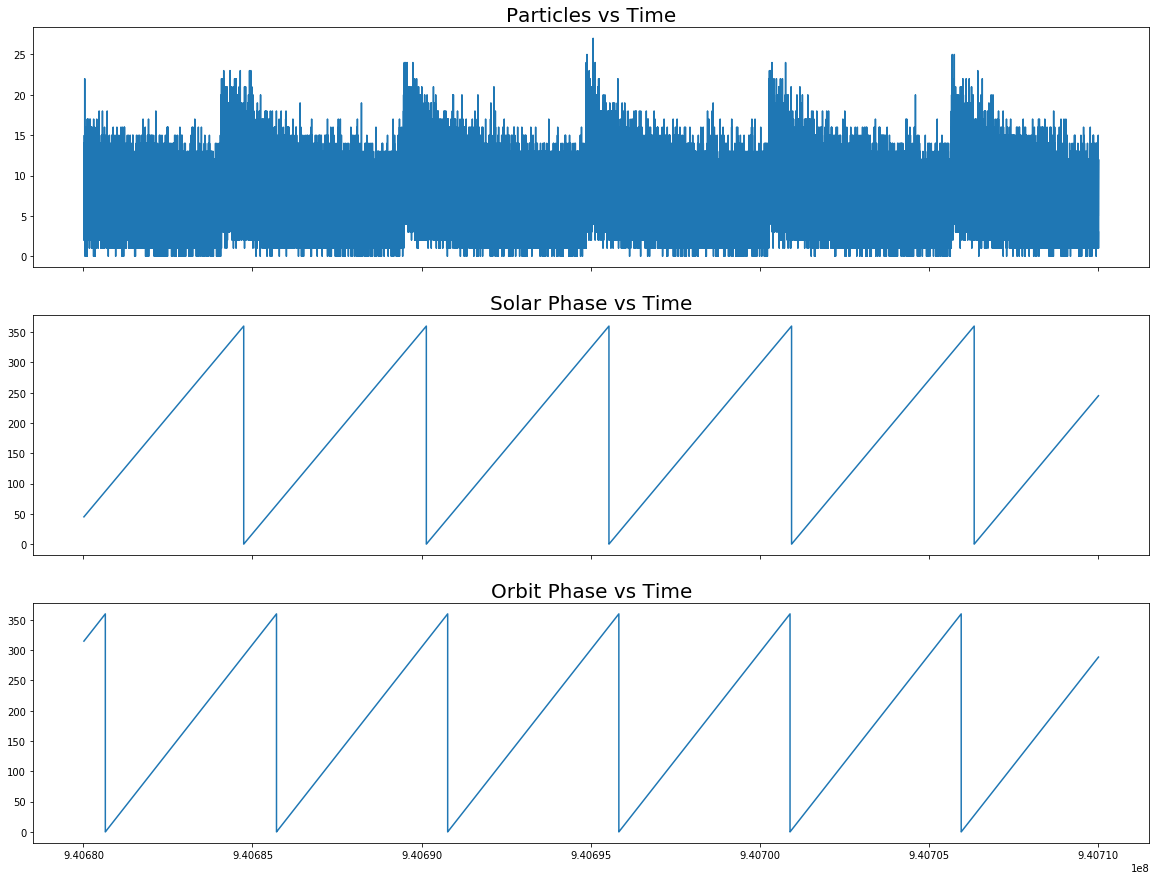

In [27]:
plt.figure(figsize=(20, 30))
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True)

N = 300000
ax1.plot(data[0,:N], data[3,:N])
ax1.set_title('Particles vs Time', fontsize=20)
ax2.plot(data[0,:N], data[2,:N])
ax2.set_title('Solar Phase vs Time', fontsize=20)
ax3.plot(data[0,:N], data[1,:N])
ax3.set_title('Orbit Phase vs Time', fontsize=20)

plt.show()

The first graph represents the number of particles detected by the satellite over the first $N=300,000$ 100 millisecond intervals. The second and third graphs represent the Solar and Orbit phases respectively over the same period. The number of particles appears to be randomly distributed, but periodic in nature. The orbit phase and solar phase are functions with a constant period representing an angle between 0 and 360 degrees, with a 90 degree phase shift between them.

The background cosmic radiation with no sources of cosmic rays should be fairly steady; there appears to be some form of signal contamination causing it to have periodic behavior.

To try and find a background with periodic signal contamination, make groups of data where the meta-data is equal (i.e., a group where all data has orbital phase at 45 degrees) and then use that data to calculate the background for a given phase. This can be achieved using a two dimensional histogram, where the x axis is the phase, the y axis is the number of cosmic rays detected in one observation, and the color of a given bin represents the probability associated with it. Each column of the histogram would represent the background for a given phase.

The above graph is a single slice of the background which varies with time/solar phase, and we can learn more with a 2d histogram of the cosmic ray counts versus either solar phase or orbit phase. The 2d histogram would represent the same thing as above, but for every solar phase value.

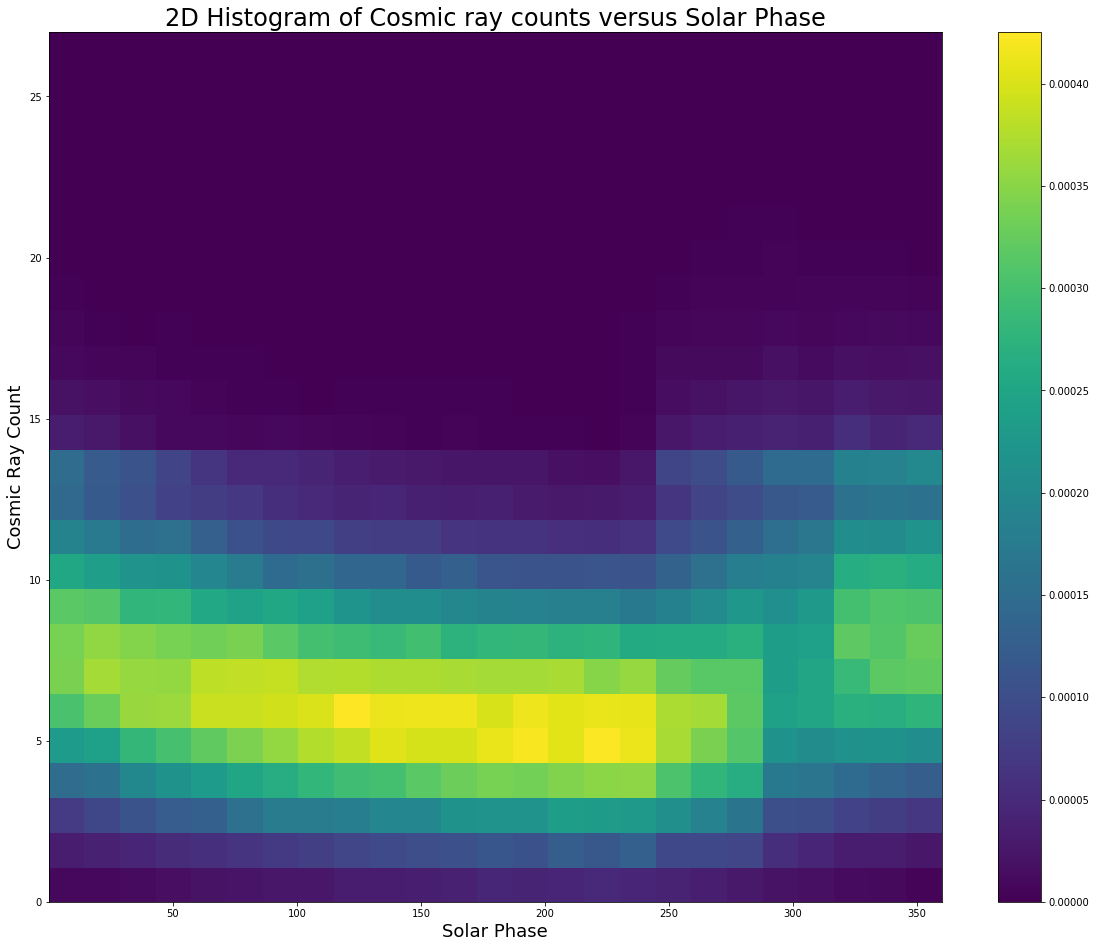

In [4]:
plt.figure(figsize=(20, 16))
h = plt.hist2d(data[1,:N], data[3,:N], bins=(25,25), density=True);
plt.title("2D Histogram of Cosmic ray counts versus Solar Phase", fontsize = 24)
plt.ylabel("Cosmic Ray Count", fontsize = 18)
plt.xlabel("Solar Phase", fontsize = 18)
plt.colorbar(h[3])
plt.show()

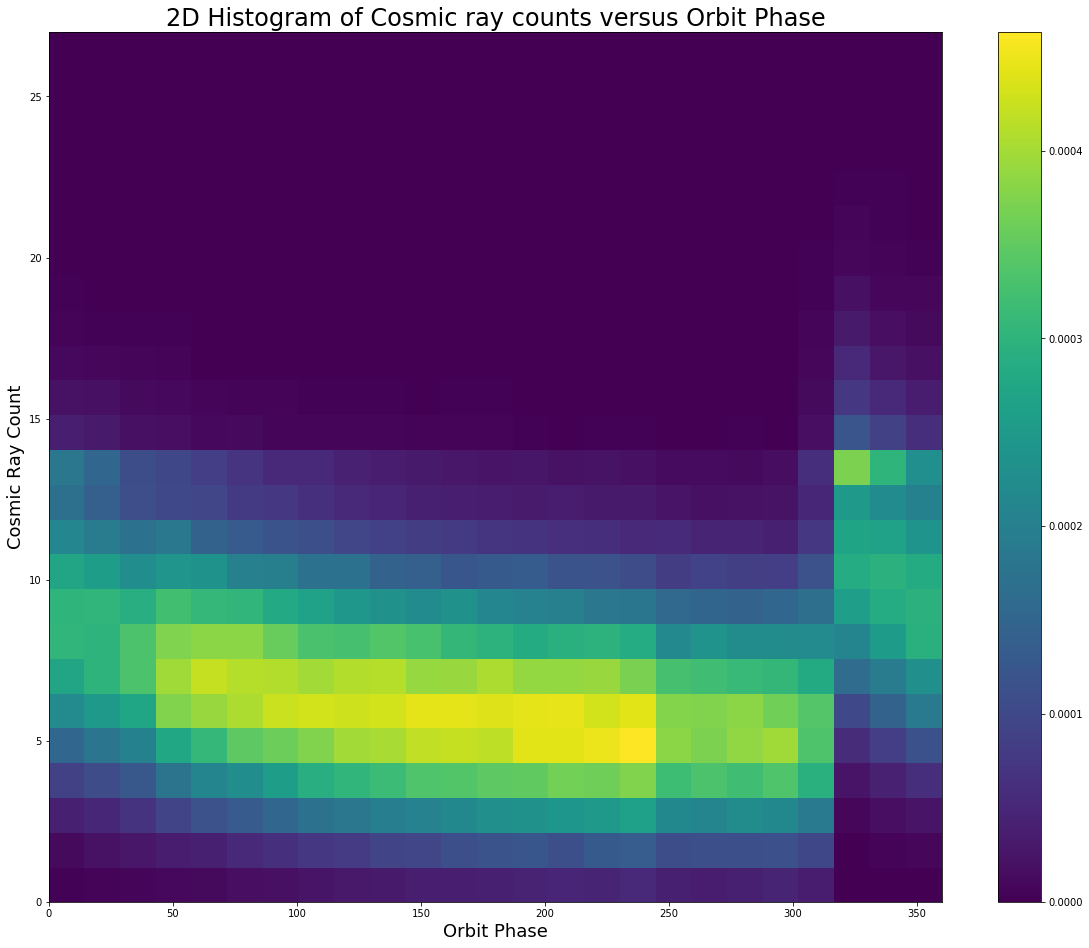

In [5]:
plt.figure(figsize=(20, 16))
h = plt.hist2d(data[2,:N], data[3,:N], bins=(25,25), density=True);
plt.title("2D Histogram of Cosmic ray counts versus Orbit Phase", fontsize = 24)
plt.ylabel("Cosmic Ray Count", fontsize = 18)
plt.xlabel("Orbit Phase", fontsize = 18)
plt.colorbar(h[3])
plt.show()

The second 2d histogram labelled "2D Histogram of Cosmic ray counts versus Orbit Phase" represents a probability mass function for the cosmic ray count for every orbit phase; consider each column of bins in the histogram a seperate pmf for that one orbit phase, or the background for that orbit phase.

The histogram demonstrates how drastically the background changes based on orbital phase; an observation would most likely record 5 rays at 240 degrees, and 13 rays at 330 degrees. This doesn't agree with the theoretical understanding that virtually all the particles detected are background cosmic rays, which come from all directions towards earth and should be independant of orbital phase. 

Gamma-ray bursts are rare events, and at 330 degrees the number of cosmic rays measured is significantly higher than at other orbital phases. Rare events shouldn't have a periodic effect, where they are measured more often at one orbital phase than another. For all the reasons stated above, it is likely there is a signal contaminating our measurement of the background especially at the orbital phase of 330 degrees.

The underlying distribution of our background is a Poisson distribution, as the cosmic rays observed come in integer quantities; now create a model using the poisson distribution and compare it to the data.

In [6]:
means = [np.mean(data[3][data[2]==i]) for i in np.arange(360)]
#means = [np.mean(data[3][data[2]==i]) for i in data[2][:54001]]
# First line is a snippet of the second, for reduced computation time

In [7]:
data[2][:1]

array([45.])

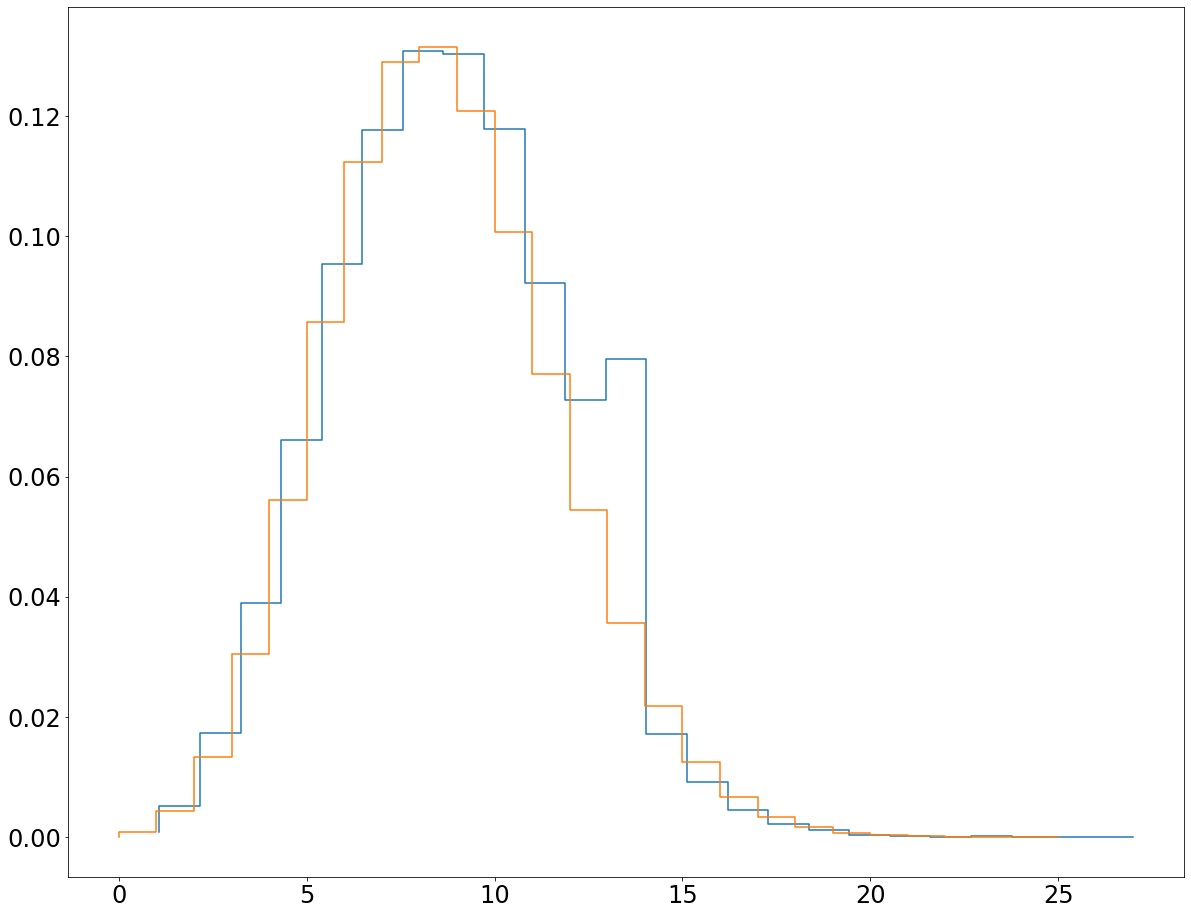

In [8]:
# Taking first column of histogram (@ orbital phase = 0),
# and normalizing so the sum of probabilities is 1
normFactor = 1/sum(h[0][0])
x = h[2][1:]
plt.figure(figsize=(20, 16))
plt.step(x, h[0][0,:]*normFactor)
plt.tick_params(labelsize = 24)


# Model using Poisson distribution and means from our data
mu = means[0]
x=np.arange(0,26)
plt.step(x, stats.poisson.pmf(x,mu))
plt.show()

In the above graph, the blue step plot is the data measured by the satellite at orbital phase of 0 degrees, taken from the histogram and normalized. The orange line is the model, a poisson distribution with the same mean as the satellite data for that orbital phase. Based on the similarity between the two plots, the poisson distribution appears to be a good model of the background.


To create a model of our background with time dependance, first we deconstruct orbital phase into a function of time and the number of cosmic rays observed into a function of orbital phase.

In [9]:
# Probability Mass Function of Cosmic Rays as function of Orbital Phase
def pmf(x, phase):
    return stats.poisson.pmf(x, means[round(phase)])
        #ROUNDING BECAUSE MEANS WAS CALCULATED ON RANGE(0,360,1)
        #Could be made more accurate, but calculating and using means 
        #over linspace(0,360,54000) would take too much time and memory.

In [10]:
dt = 0.1 #seconds per observation
indexOrbitPeriod = np.arange(0,len(data[2]))[data[2]==data[2][0]][1]
orbitPeriod = indexOrbitPeriod*dt
print("# of Observations in one period: ", indexOrbitPeriod)
start = data[0][0]

# Orbital Phase as function of Time
def orbitPhase(timeElapsed):
    currOrbitTime = timeElapsed%5400
    if currOrbitTime == 0:
        return 0
    else:
        return 360*(currOrbitTime/5400)

def phaseToTime(phase):
    return phase/360*5400

# of Observations in one period:  54000


Start time:  940680016.0
Elapsed time:  8210
Orbital Phase:  187.33333333333334


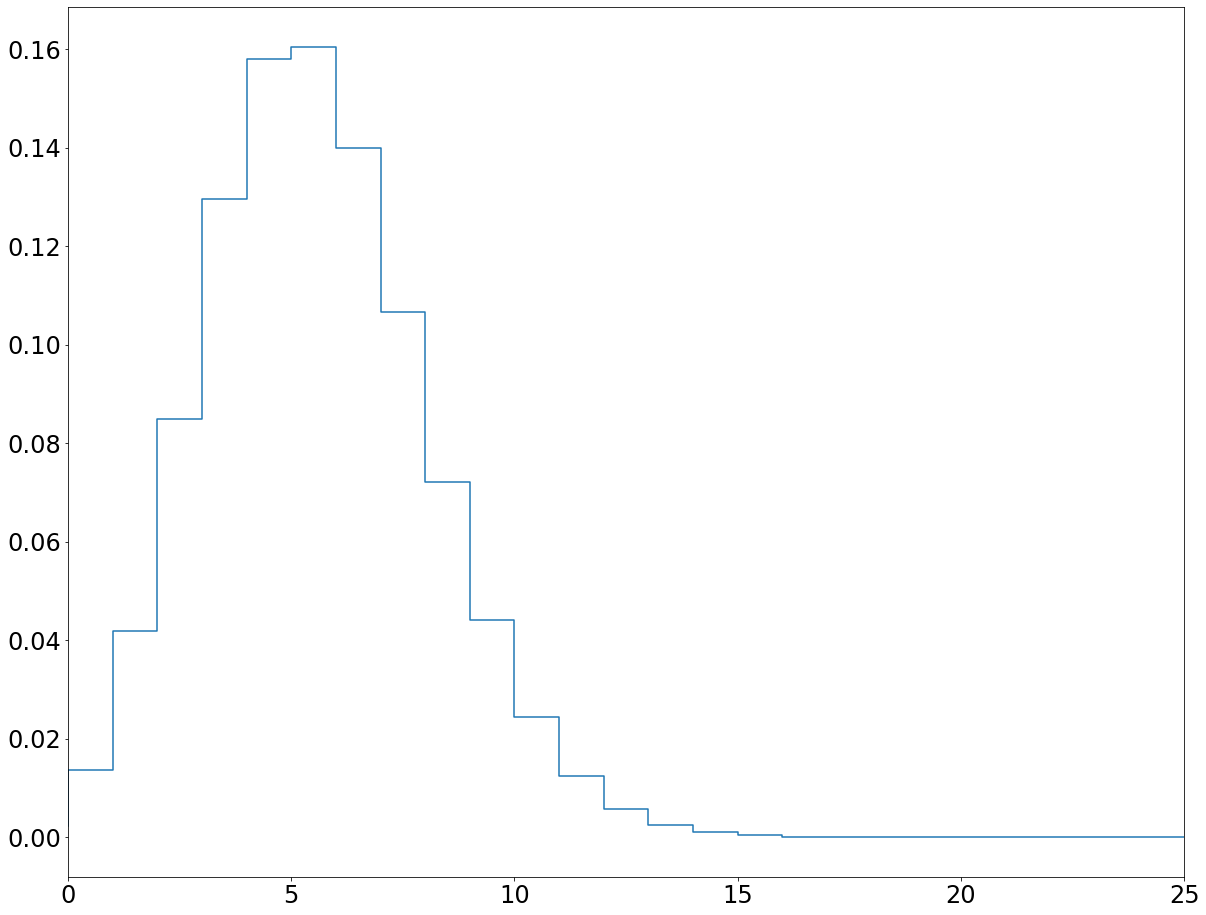

Orbital Phase (real):  187.19653333250682


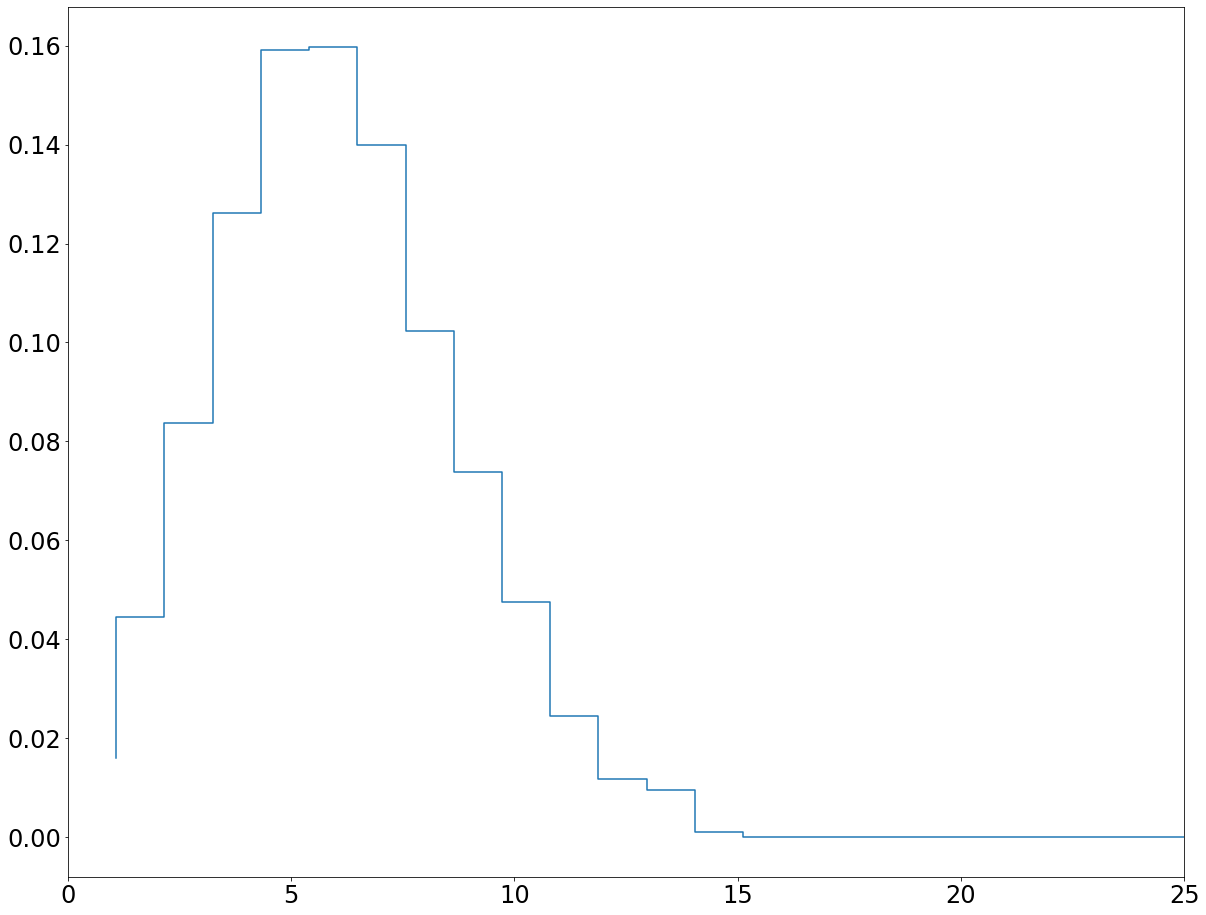

In [11]:
def model(timeElapsed):
    x = np.arange(0,26)
    phase = orbitPhase(timeElapsed)
    arr = pmf(x, phase)
    return x, phase, arr
    
def plotModel(timeElapsed, doPrint=True):
    x, phase, arr = model(timeElapsed)
    plt.figure(figsize=(20, 16))
    plt.tick_params(labelsize = 24)
    plt.xlim([0,25])
    plt.step(x, arr)
    if doPrint:
        print("Start time: ", data[0][0])
        print("Elapsed time: ", timeElapsed)
        print("Orbital Phase: ", phase)
    plt.show()

plotModel(8210)

plt.figure(figsize=(20, 16))
plt.tick_params(labelsize = 24)
normFactor = 1/sum(h[0][13])
x = h[2][1:]
print("Orbital Phase (real): ", h[1][13])
plt.xlim([0,25])
plt.step(x, h[0][13]*normFactor)
plt.show()

The above graph is from our time-dependant model for the background 8210 seconds after the measurements started at gps time 940680016s, compared again to our actual data as taken from the 2d histogram. Again, the plots are very similiar which means the model is fairly good.

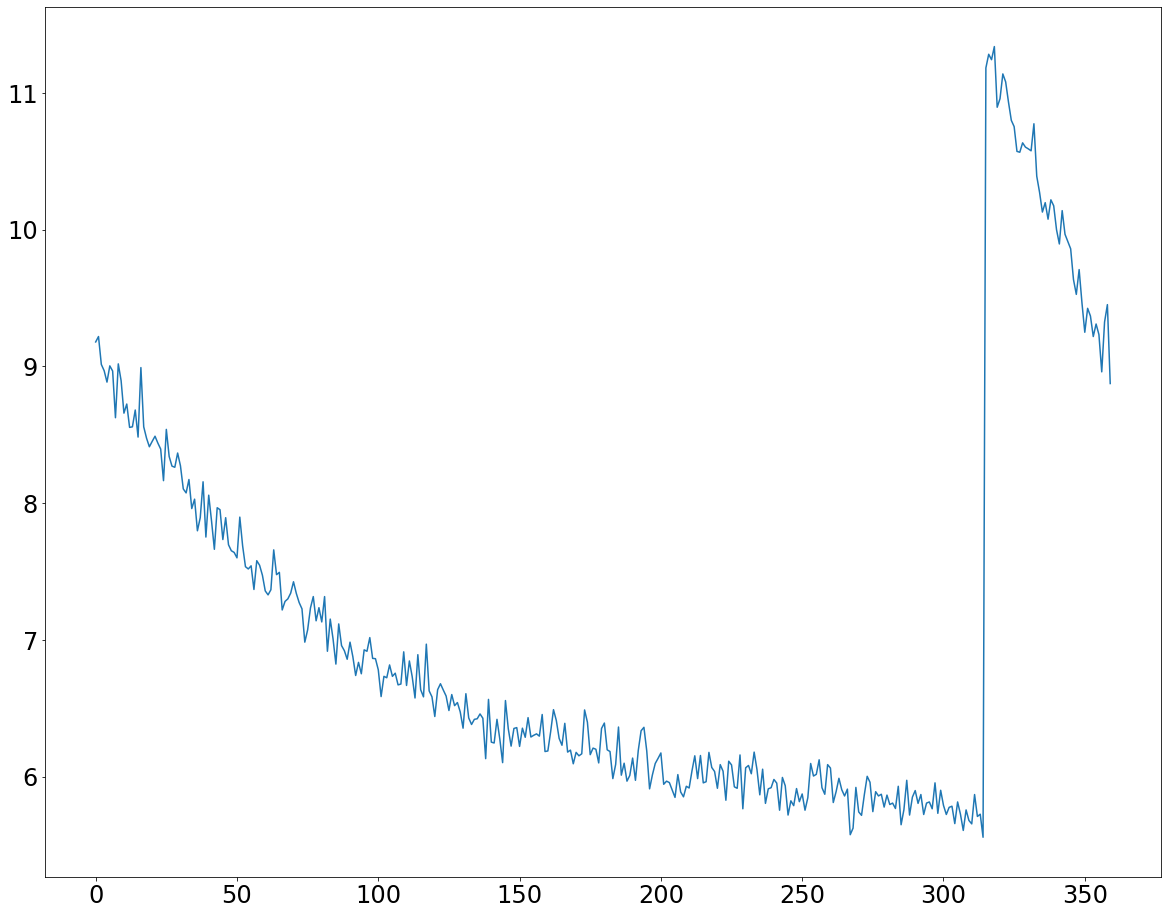

In [12]:
plt.figure(figsize=(20, 16))
plt.tick_params(labelsize = 24)
plt.plot(np.arange(0,360), means)
plt.show()

In [13]:
minPhase = np.argmin(means)
minCount = means[minPhase]
print(f"Lowest average count of {minCount:.1f} at orbital phase {minPhase:.1f}")
maxPhase = np.argmax(means)
maxCount = means[maxPhase]
print(f"Highest average count of {maxCount:.1f} at orbital phase {maxPhase:.1f}")

Lowest average count of 5.6 at orbital phase 314.0
Highest average count of 11.3 at orbital phase 318.0


4 degrees of orbital phase seperate the lowest and highest average cosmic ray counts in our real data. using our model, it is possible to find values corresponding to the 5 sigma threshold at different times/orbital phases.

In [14]:
five_sig = stats.norm.sf(5)
minSig = stats.poisson.isf(five_sig, minCount)
maxSig = stats.poisson.isf(five_sig, maxCount)
minSigTime = phaseToTime(minPhase)
maxSigTime = phaseToTime(maxPhase)
print(f"Minimum signal of {minSig:.0f}, {minSigTime:.0f} seconds after the experiment started")
print(f"Maximum signal of {maxSig:.0f}, {maxSigTime:.0f} seconds after the experiment started")

Minimum signal of 21, 4710 seconds after the experiment started
Maximum signal of 32, 4770 seconds after the experiment started


At 4710 seconds after the experiment started (gps time 940684726) a measurement of 21 cosmic rays over 100 milliseconds would have qualified for a 5 sigma detection; just 60 seconds later, a detection of 32 cosmic rays over 100 milliseconds would be required for a discovery to qualify as a 5 sigma event. Using the time dependent model, it would be possible to calculate the sigma significance of any new data even with this rapidly changing sensitivity threshold given the gps time with each 100ms observation.

This signal contamination seen at 330 degrees orbital phase is caused by the South Atlantic Anomaly, an area where the Earth's inner Van Allen radiation belt comes closest to the Earth's surface, which leads to more cosmic rays in this region. 

If I didn't already know the answer, I'd say it could be caused by a gamma ray source on the earth shooting directly toward the satellite when it is at an orbital phase of 330 degrees, or perhaps the sun is that source with a maximum number of gamma rays hitting the satellite at its' orbital phase of 330 degrees and otherwise obscured by the earth (hence the periodically high cosmic ray counts).

## Problem 2

Given a stack of images of the cosmos, find the faintest stars.

The images are 200 pixels by 200 pixels, and there are 10 of them.

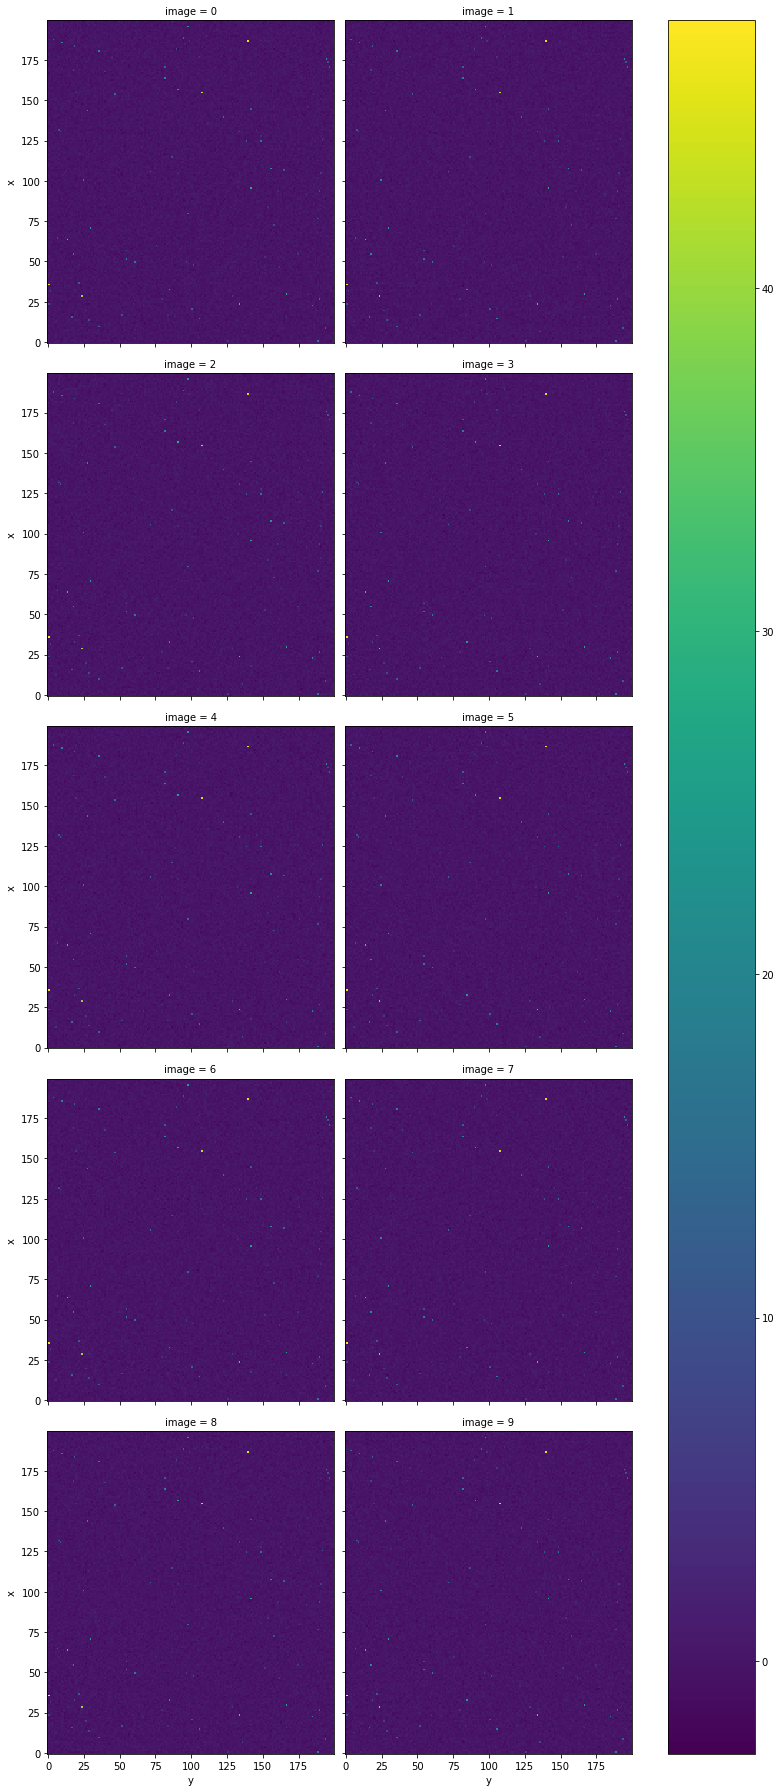

In [15]:
hf = h5py.File('images.h5', 'r')
stack = xr.DataArray(hf.get('imagestack')[:,:,:], coords=[np.arange(200), np.arange(200),np.arange(10)], dims=['x', 'y', 'image']).transpose('image','x','y')
stack.plot(center=False, col='image', col_wrap=2, size=5)
hf.close()
plt.show()

Each of the 10 images seems the same under cursory examination, and since stars do not change in brightness over time the background should not be time dependant. To find the background pdf, one plan is to sum the pictures and then cull outliers at a chosen sensitivity threshold, after which points stop being background and start being faint stars.

First, a log-scale histogram of the stack of images

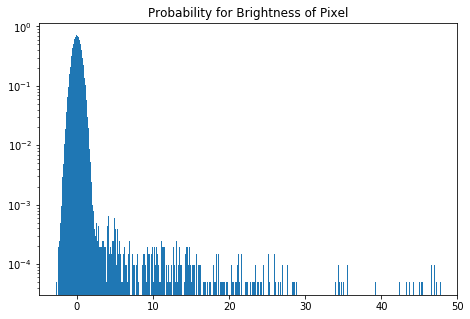

In [16]:
stack.plot.hist(bins=1000, density=True, size=5)
plt.title("Probability for Brightness of Pixel")
plt.xlim([-5,50])
plt.yscale('log')
plt.show()

There might be signal contamination in the form of distant supernovas, however it's hard to tell without doing further exploration.

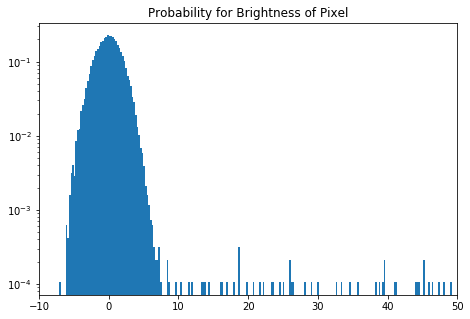

In [17]:
stack_sum = sum(stack)
stack_sum.plot.hist(bins=2000, density=True, size=5)
plt.title("Probability for Brightness of Pixel")
plt.xlim([-10,50])
plt.yscale('log')
plt.show()

In [18]:
stack_sum_trimmed = stack_sum.where(stack_sum < 10)
mean = stack_sum_trimmed.mean().values
std = stack_sum_trimmed.std().values
print(f"Mean: {mean:.3f}")
print(f"Standard Deviation: {std:.3f}")

Mean: -0.001
Standard Deviation: 1.778


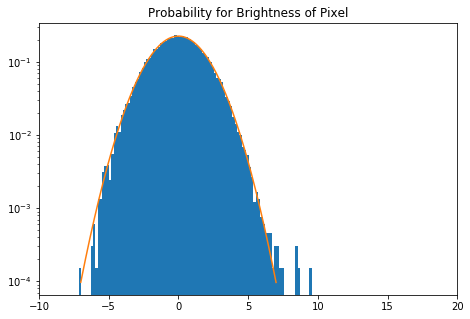

In [19]:
stack_sum_trimmed.plot.hist(bins=100, density=True, size=5)
x = np.linspace(-7,7,1000)
pdf = stats.norm.pdf(x, loc=mean, scale=std)
plt.plot(x, pdf)
plt.title("Probability for Brightness of Pixel")
plt.xlim([-10,20])
plt.yscale('log')
plt.show()

After removing the obvious outliers by visual examination, the remaining data is found to have a mean and standard deviation of -0.001 and 1.778 respectively. Plotting the probability density function of a Gaussian distribution on top of the histogram, they look exactly the same. 

Having created the background pdf for the sum of 10 pictures, now to determine the sensitivity threshold for what qualifies as a faint star,

In [20]:
def detect(threshold):
    threshold_prob = stats.norm.sf(threshold)
    signal = stats.norm.isf(threshold_prob, loc=mean, scale=std)
    print(f"A pixel with intensity of {signal:.2f} would be a {threshold} sigma event")
    n = stack_sum.where(stack_sum > signal).count().values
    print(f"In the sum of all pictures, there are {n} pixels that are stars with {threshold} sigma certainty.")


detect(5) #Threshold in sigma

A pixel with intensity of 8.89 would be a 5 sigma event
In the sum of all pictures, there are 125 pixels that are stars with 5 sigma certainty.


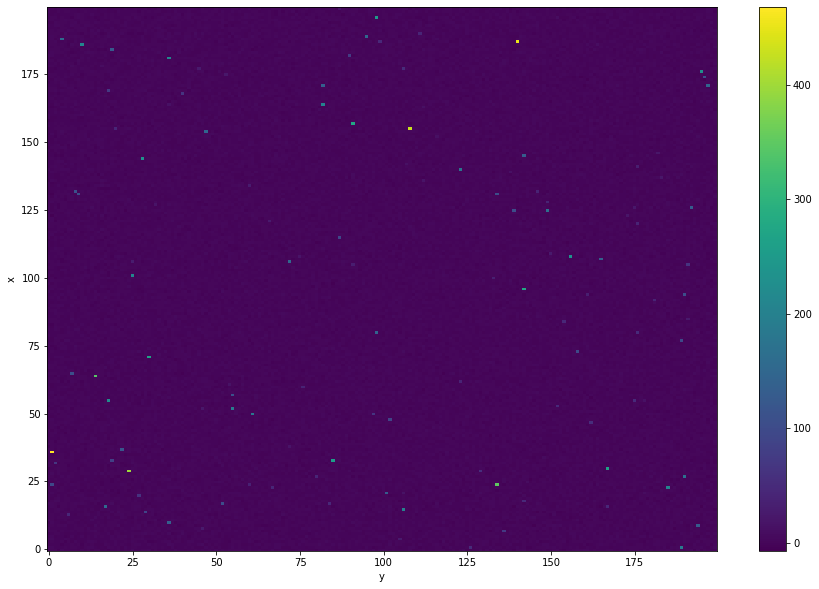

In [21]:
stack_sum.plot(center=False, col_wrap=2, size=10)

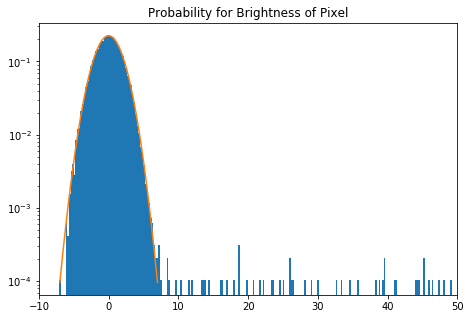

In [22]:
stack_sum.plot.hist(bins=2000, density=True, size=5)
plt.plot(x, pdf)
plt.title("Probability for Brightness of Pixel")
plt.xlim([-10,50])
plt.yscale('log')
plt.show()

In [23]:
detect(10)

A pixel with intensity of 17.78 would be a 10 sigma event
In the sum of all pictures, there are 114 pixels that are stars with 10 sigma certainty.


The plotted image above is the sum of all images, and it sharply brings the persistent features (like stars) into contrast with the low-intensity background. Below, the log-scale histogram with all outliers included the probability density function of the background plotted on top; Each spike past ~9 on the x axis represents a star, with 5 sigma certainty. The difference between 5 sigma certainty and 10 sigma certainty is 11 stars -- these are probably the faintest stars that are almost certain to exist.

My partner, who is looking for transient events, would have a different pdf than me because I am looking for persistent events; the pdf I use will be summed over multiple trials, which will help looking for persistent features,  would hinder searching for events which occur once in many trials. My partner, looking for transient events, would rather look at the difference between each image and create a pdf for the average ambient noise created by the differencing, and use that pdf to analyze each picture-difference for discoveries.